<a href="https://www.kaggle.com/code/ravaghi/s05e04-podcast-listening-time-ridge?scriptVersionId=234540636" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ydf scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import keras
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e4/train.csv"
    test_path = "/kaggle/input/playground-series-s5e4/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e4/sample_submission.csv"

    original_path = "/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv"
    
    target = "Listening_Time_minutes"
    metric = "RMSE"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

cat_cols = test.select_dtypes(include="object").columns.tolist()
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")
original[cat_cols] = original[cat_cols].astype(str).astype("category")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, X_original=None, y_original=None):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            if X_original is not None and y_original is not None:
                X_train = pd.concat([X_train, X_original])
                y_train = pd.concat([y_train, y_original])
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, oof_preds)
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):                       
        oof_preds = np.zeros(X.shape[0])
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
                
            model = clone(self.model)
            model.fit(X_train, y_train)

            oof_preds[val_idx] = model.predict(X_val)
                
            del X_train, y_train, X_val, y_val
            gc.collect() 
            
        return root_mean_squared_error(y, oof_preds)
        
    def _save_results(self, oof_preds, test_preds, cv_score):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            model_name = self.model.__class__.__name__.lower().replace("regressor", "")
            if model_name == "lgbm":
                model_name = "lgbm-" + self.model.boosting_type
            
            if model_name == "bagging":
                model_name = "keras-ann"
            
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            joblib.dump(oof_preds, f"oof/{model_name}/{model_name}_oof_preds_{cv_score:.6f}.pkl")
            joblib.dump(test_preds, f"oof/{model_name}/{model_name}_test_preds_{cv_score:.6f}.pkl")
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=500), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=500
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=500, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
histgb_params = {
    "categorical_features": "from_dtype",
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [7]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [8]:
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, X_original, y_original)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 12.794589
--- Fold 2 - RMSE: 12.834127
--- Fold 3 - RMSE: 12.853394
--- Fold 4 - RMSE: 12.834924
--- Fold 5 - RMSE: 12.792689

------ Overall RMSE: 12.821996 - Average RMSE: 12.821945


## LightGBM (gbdt)

In [9]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9083	valid_0's l2: 166.625
[1000]	valid_0's rmse: 12.8592	valid_0's l2: 165.36
[1500]	valid_0's rmse: 12.8302	valid_0's l2: 164.615
[2000]	valid_0's rmse: 12.8103	valid_0's l2: 164.103
[2500]	valid_0's rmse: 12.7952	valid_0's l2: 163.718
[3000]	valid_0's rmse: 12.7822	valid_0's l2: 163.384
[3500]	valid_0's rmse: 12.7736	valid_0's l2: 163.164
[4000]	valid_0's rmse: 12.7632	valid_0's l2: 162.899
[4500]	valid_0's rmse: 12.7553	valid_0's l2: 162.699
[5000]	valid_0's rmse: 12.75	valid_0's l2: 162.562
[5500]	valid_0's rmse: 12.7441	valid_0's l2: 162.412
[6000]	valid_0's rmse: 12.7408	valid_0's l2: 162.327
[6500]	valid_0's rmse: 12.7358	valid_0's l2: 162.201
Early stopping, best iteration is:
[6501]	valid_0's rmse: 12.7357	valid_0's l2: 162.199

--- Fold 1 - RMSE: 12.735190


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9673	valid_0's l2: 168

## LightGBM (goss)

In [10]:
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, X_original, y_original)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 12.9554	valid_0's l2: 167.843
[1000]	valid_0's rmse: 12.9106	valid_0's l2: 166.683
[1500]	valid_0's rmse: 12.8836	valid_0's l2: 165.987
[2000]	valid_0's rmse: 12.8631	valid_0's l2: 165.459
[2500]	valid_0's rmse: 12.85	valid_0's l2: 165.123
[3000]	valid_0's rmse: 12.8401	valid_0's l2: 164.868
[3500]	valid_0's rmse: 12.8332	valid_0's l2: 164.692
[4000]	valid_0's rmse: 12.8268	valid_0's l2: 164.528
[4500]	valid_0's rmse: 12.8214	valid_0's l2: 164.387
Early stopping, best iteration is:
[4825]	valid_0's rmse: 12.8191	valid_0's l2: 164.33

--- Fold 1 - RMSE: 12.818963


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 13.0111	valid_0's l2: 169.288
[1000]	valid_0's rmse: 12.9616	valid_0's l2: 168.003
[1500]	valid_0's rmse: 12.9321	valid_0's l2: 167.238
[2000]	valid_0's rmse: 12.9122	valid_0's l2: 166.725
[2500]	valid_0's rmse: 12.8969	valid_0's l2: 166

## XGBoost

In [11]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, X_original, y_original)

Training XGBRegressor

[0]	validation_0-rmse:26.44402
[500]	validation_0-rmse:12.99048
[1000]	validation_0-rmse:12.94248
[1500]	validation_0-rmse:12.91497
[2000]	validation_0-rmse:12.89701
[2500]	validation_0-rmse:12.88511
[3000]	validation_0-rmse:12.87388
[3500]	validation_0-rmse:12.86640
[4000]	validation_0-rmse:12.85940
[4500]	validation_0-rmse:12.85480
[5000]	validation_0-rmse:12.85226
[5075]	validation_0-rmse:12.85208

--- Fold 1 - RMSE: 12.851567


[0]	validation_0-rmse:26.47696
[500]	validation_0-rmse:13.04341
[1000]	validation_0-rmse:12.98781
[1500]	validation_0-rmse:12.96237
[2000]	validation_0-rmse:12.94277
[2500]	validation_0-rmse:12.92851
[3000]	validation_0-rmse:12.91941
[3500]	validation_0-rmse:12.91215
[4000]	validation_0-rmse:12.90643
[4330]	validation_0-rmse:12.90367

--- Fold 2 - RMSE: 12.903359


[0]	validation_0-rmse:26.44779
[500]	validation_0-rmse:13.04347
[1000]	validation_0-rmse:12.99346
[1500]	validation_0-rmse:12.96552
[2000]	validation_0-rmse:12.94495
[2500]	

## CatBoost

In [12]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, X_original, y_original)

Training CatBoostRegressor

0:	learn: 26.1835620	test: 26.1668139	best: 26.1668139 (0)	total: 747ms	remaining: 1h 2m 16s
500:	learn: 12.8747408	test: 13.0112816	best: 13.0112816 (500)	total: 4m 52s	remaining: 43m 50s
1000:	learn: 12.5828187	test: 12.9650688	best: 12.9650688 (1000)	total: 10m 3s	remaining: 40m 11s
1500:	learn: 12.3140964	test: 12.9412824	best: 12.9412364 (1499)	total: 15m 19s	remaining: 35m 43s
2000:	learn: 12.0689243	test: 12.9254291	best: 12.9254291 (2000)	total: 20m 41s	remaining: 31m 1s
2500:	learn: 11.8356361	test: 12.9134400	best: 12.9133959 (2494)	total: 25m 58s	remaining: 25m 57s
3000:	learn: 11.6109653	test: 12.9023702	best: 12.9023702 (3000)	total: 31m 17s	remaining: 20m 50s
3500:	learn: 11.3897462	test: 12.8929743	best: 12.8928565 (3497)	total: 36m 33s	remaining: 15m 39s
4000:	learn: 11.1834848	test: 12.8861167	best: 12.8861167 (4000)	total: 41m 51s	remaining: 10m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.88239814
bestIteration

## Yggdrasil

In [13]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [14]:
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil"], test_preds["Yggdrasil"], scores["Yggdrasil"], _ = ydf_trainer.train(X, y, X_test, X_original, y_original)

Training YDFXRegressor

--- Fold 1 - RMSE: 12.940558
--- Fold 2 - RMSE: 12.988787
--- Fold 3 - RMSE: 12.986136
--- Fold 4 - RMSE: 12.987160
--- Fold 5 - RMSE: 12.939877

------ Overall RMSE: 12.968561 - Average RMSE: 12.968504


## AutoGluon

In [15]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e04-podcast-listening-time-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

## Neural network

In [16]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path)
original = original.dropna(subset=[CFG.target])
original = original.drop_duplicates()

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

X_original = original.drop(CFG.target, axis=1)
y_original = original[CFG.target]

In [17]:
X_test.loc[X_test["Episode_Length_minutes"] > 500, "Episode_Length_minutes"] = None

In [18]:
cat_cols = ['Podcast_Name', 'Episode_Title']
ohe_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ohe_cols),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), cat_cols),
            ('impute-nums', make_pipeline(SimpleImputer(strategy='mean'), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), num_cols),
        ]
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)
X_original = pipeline.transform(X_original)

In [19]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [20]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

In [21]:
nn_trainer = Trainer(BaggingRegressor(
    nn_model,
    n_estimators=5,
    random_state=CFG.seed,
))
    
oof_preds["KerasANN"], test_preds["KerasANN"], scores["KerasANN"], _ = nn_trainer.train(X, y, X_test, X_original, y_original)

Training BaggingRegressor

--- Fold 1 - RMSE: 13.156207
--- Fold 2 - RMSE: 13.223311
--- Fold 3 - RMSE: 13.221234
--- Fold 4 - RMSE: 13.213069
--- Fold 5 - RMSE: 13.174721

------ Overall RMSE: 13.197736 - Average RMSE: 13.197708


# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-04-18 05:52:13,131] A new study created in memory with name: no-name-54d8de83-7289-4f23-9349-aabbe32e6723
[I 2025-04-18 05:52:20,377] Trial 1 finished with value: 12.608675976840798 and parameters: {'alpha': 2.467304140798221, 'tol': 7.319722866659922e-05}. Best is trial 1 with value: 12.608675976840798.
[I 2025-04-18 05:52:20,887] Trial 2 finished with value: 12.608675976976908 and parameters: {'alpha': 2.394034378915606, 'tol': 0.005252581320285115}. Best is trial 1 with value: 12.608675976840798.
[I 2025-04-18 05:52:21,350] Trial 3 finished with value: 12.608675964381435 and parameters: {'alpha': 9.17509868291743, 'tol': 0.005718027769769413}. Best is trial 3 with value: 12.608675964381435.
[I 2025-04-18 05:52:21,388] Trial 0 finished with value: 12.608675972932337 and parameters: {'alpha': 4.571347230287276, 'tol': 0.004701009288015551}. Best is trial 3 with value: 12.608675964381435.
[I 2025-04-18 05:52:29,761] Trial 6 finished with value: 12.60867597568271 and parameters:

In [25]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 9.999005657730866,
  "tol": 0.00732474641260451
}


In [26]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
ridge_oof_preds, ridge_test_preds, scores["Ridge (ensemble)"], ridge_coeffs = ridge_trainer.train(X, y, X_test)

Training Ridge

--- Fold 1 - RMSE: 12.571979
--- Fold 2 - RMSE: 12.618134
--- Fold 3 - RMSE: 12.611602
--- Fold 4 - RMSE: 12.630469
--- Fold 5 - RMSE: 12.610838

------ Overall RMSE: 12.608676 - Average RMSE: 12.608604


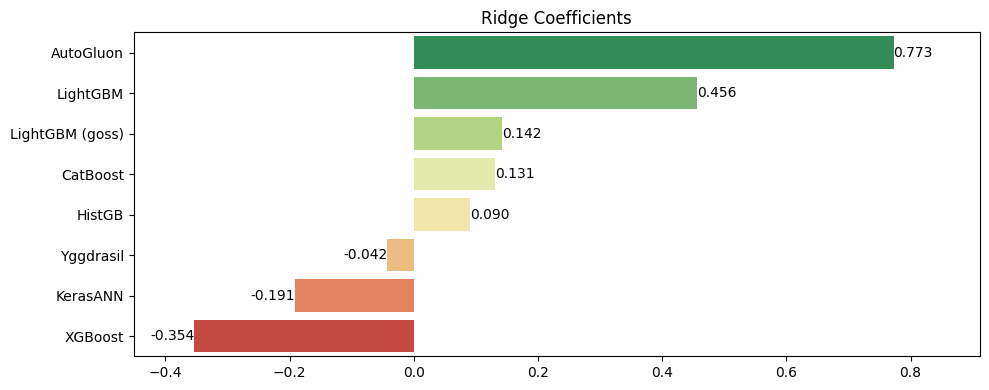

In [27]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [28]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,54.734028
1,750001,18.606749
2,750002,49.968782
3,750003,76.857492
4,750004,48.177964


# Results

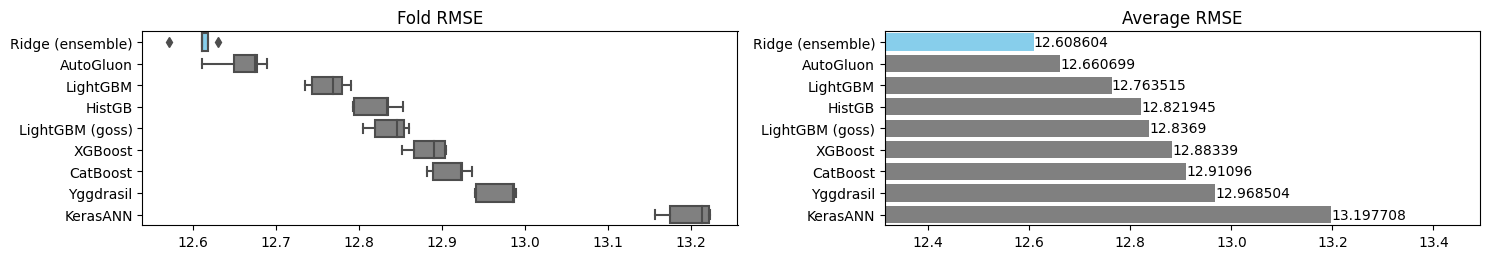

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree("catboost_info", ignore_errors=True)